In [4]:
import os
import json
import pickle
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from glob import glob

from sage.config.config import DataArguments, TrainingArguments, MiscArguments

from sage.config import get_logger, logger_conf
from sage.data import get_dataloader
from sage.models import build_model
from sage.utils import seed_everything
from sage.xai.utils import z_norm, load_mni152_template, _mni

import torch

from nilearn import plotting
import nibabel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from captum.attr import LayerGradCam, LayerAttribution

In [2]:
data_args, training_args, misc_args = (
    DataArguments(),
    TrainingArguments(),
    MiscArguments(),
)
misc_args.output_dir = "./"
logger_conf["handlers"]["file_handler"]["filename"] = misc_args.output_dir + "/run.log"
logger = get_logger(logger_conf)

In [6]:
base_path = "/Volumes/WD_BLACK/repvgg_ckpts/"

get_path = lambda f: os.path.join(base_path, f)

In [7]:
pkl_fnames = glob(f"{base_path}/*/*/*.pkl")

In [8]:
def pkl_to_df(fname, target_col):

    with open(fname, "rb") as f:
        pkl = pickle.load(f)

    return pd.DataFrame(pkl).T[target_col]

In [10]:
def result_pkl_parser(fname, target_col="test_metric"):

    seed = fname.split("-")[-1].split("/")[0]
    df = pkl_to_df(fname, target_col)
    return seed, df

In [11]:
total_df = {}
for fname in pkl_fnames:

    seed, col = result_pkl_parser(fname)
    total_df[seed] = col

total_df = pd.DataFrame(total_df)

In [60]:
# Best MAE mean±std
total_df.min().mean(), total_df.min().std()

(5.435931105613708, 0.28641891717662676)

In [77]:
# Last Epoch MAE mean±std
(1 - total_df.isna()).sum().mean(), (1 - total_df.isna()).sum().std()

68.47

In [97]:
# Last MAE mean±std
last_vals = []
for col, index in zip(total_df, total_df.apply(pd.Series.last_valid_index).values):
    
    last_vals.append(total_df.loc[index, col])

np.array(last_vals).mean(), np.array(last_vals).std()

(6.1541205453872685, 0.913664702952492)

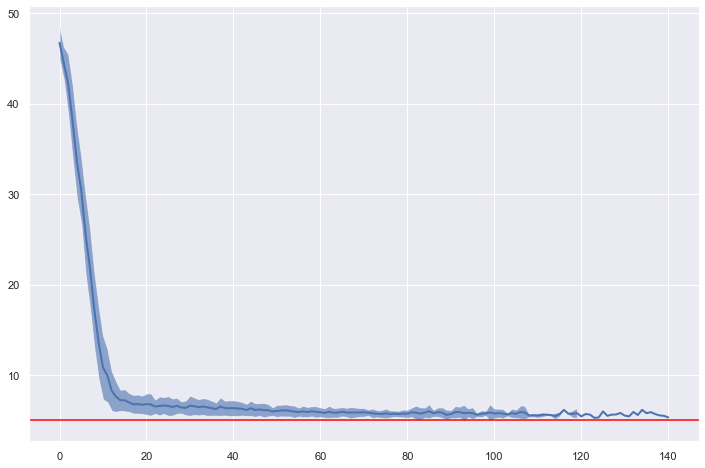

In [120]:
fig, ax = plt.subplots(figsize=(12, 8))

mean_vals = total_df.mean(axis=1)
std_vals = total_df.std(axis=1)
ax.plot(range(141), mean_vals, linewidth=2)
ax.fill_between(range(141), mean_vals-std_vals, mean_vals+std_vals, alpha=0.6)
ax.axhline(5, color="red")

In [102]:
with open("./data/augment_reg_test_100.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {
        e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])
    }

from sage.legacy.miccai_analysis import Result
augment = Result(augment_results)

In [112]:
total_df.mean(axis=1).values

array([46.7147974 , 44.41603477, 42.13495998, 38.05553589, 33.59865011,
       30.43026011, 25.53036184, 21.8569763 , 17.23018331, 13.61147176,
       10.84803142,  9.97477072,  8.26642982,  7.63962962,  7.2260549 ,
        7.22958981,  6.98516661,  6.78929603,  6.81023263,  6.73370581,
        6.80089369,  6.76684289,  6.5316739 ,  6.60315635,  6.65852877,
        6.59421498,  6.48486292,  6.62446281,  6.44031364,  6.39220308,
        6.63140729,  6.57488767,  6.45962401,  6.54586485,  6.44541091,
        6.36412757,  6.25741763,  6.53799603,  6.36754377,  6.34887788,
        6.36675932,  6.32556146,  6.28133969,  6.15834623,  6.3417043 ,
        6.15588165,  6.21868495,  6.14431574,  6.13278202,  5.99023545,
        6.05166898,  6.0968083 ,  6.10877511,  6.0631174 ,  5.96577111,
        5.93124915,  6.00679929,  5.92785605,  6.0112106 ,  5.94938122,
        5.91269714,  5.83186278,  5.95090531,  5.85080308,  5.86027892,
        5.96995107,  5.88726236,  5.86236903,  5.88363726,  5.88

In [159]:
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]
best_values_repvgg = total_df.min().values.tolist()

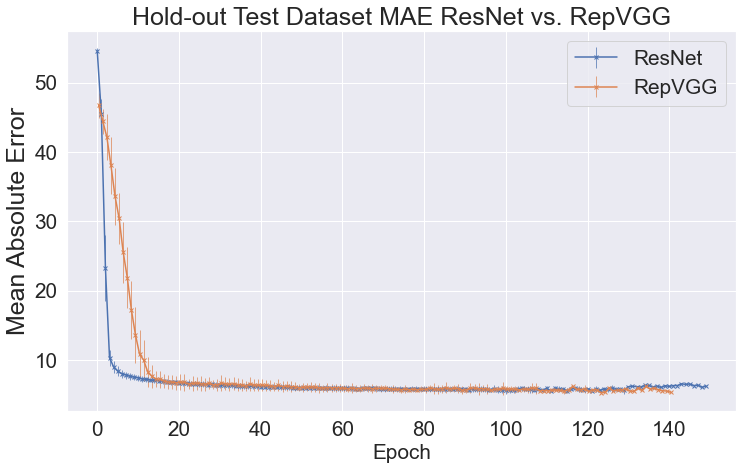

In [129]:
plt.figure(figsize=(12, 7))

plt.title("Hold-out Test Dataset MAE ResNet vs. RepVGG", size=25)
plt.xlabel("Epoch", size="xx-large")
plt.ylabel("Mean Absolute Error", size=25)
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")

plt.errorbar(
    np.array(list(augment.mean.keys())),
    list(augment.mean.values()),
    ms=4.5,
    marker="x",
    yerr=list(augment.std.values()),
    label="ResNet",
    elinewidth=0.7,
)
plt.errorbar(
    total_df.mean(axis=1).index + 0.35,
    total_df.mean(axis=1).values,
    ms=4.5,
    marker="x",
    yerr=total_df.std(axis=1),
    label="RepVGG",
    elinewidth=0.7,
)

plt.legend(prop={"size": "xx-large"})

In [12]:
def seed_to_ckpt(seed):
    seed_series = total_df[[str(seed)]]
    seed_series = seed_series[:seed_series.last_valid_index()]

    ckpts = [(e[0], float(e[1])) for e in zip(seed_series.index, seed_series.values)]
    return ckpts

In [31]:
def mean(lst):

    try:
        return sum(lst) / len(lst)
    except:
        return sum([_[0] for _ in lst]) / len([_[0] for _ in lst])

def find_first_reached(ckpts, point):

    """
    ckpts: list of tuples [(0, MAE0), (1, MAE1), ...]
    point: float
        when the given checkpoint reached the given point for the first time.
    """
    candidate_prev, candidate_next = None, None
    for epoch, mae in ckpts:

        if mae > point:
            candidate_prev = (epoch, mae)
        else:
            candidate_next = (epoch, mae)
            break

    if candidate_prev is None:
        # Every MAE is smaller than the given point
        return (0, -1)
    elif candidate_next is None:
        # Every MAE is larger than
        return (-1, -1)
    elif candidate_prev is None and candidate_next is None:
        print("Something is wrong...")
        return None

    if (candidate_prev[1] - point) >= (point - candidate_next[1]):
        return candidate_next
    else:
        return candidate_prev

def first_reached_maes(point):

    maes = [find_first_reached(seed_to_ckpt(seed), point)[1] for seed in total_df]
    return list(filter(lambda x: x != -1, maes)), mean(
        list(filter(lambda x: x != -1, maes))
    )

def first_reached_indices(point):

    indices = [find_first_reached(seed_to_ckpt(seed), point)[0] for seed in total_df]
    return list(filter(lambda x: x != -1, indices)), mean(
        list(filter(lambda x: x != -1, indices))
    )

In [47]:
start = 10
end = total_df.min().min()
point = start

x, y, naive_ckpts = [], [], []
x_min, y_min = [], []
while True:

    start -= 0.01
    point = start
    try:
        naive_mae_list, naive_mean_mae = first_reached_maes(start)
        # naive_mae_list, naive_mean_mae = first_reached_maes("naive_nonreg", start)
        naive_error = abs(point - naive_mean_mae) / naive_mean_mae
        naive_ckpts.append(len(naive_mae_list))
    except ZeroDivisionError:
        naive_error = 0
        naive_ckpts.append(0)

    err = naive_error

    if err < 0.008:
        x_min.append(point)
        y_min.append(err)

    x.append(point)
    y.append(err)

    if point < end:
        break

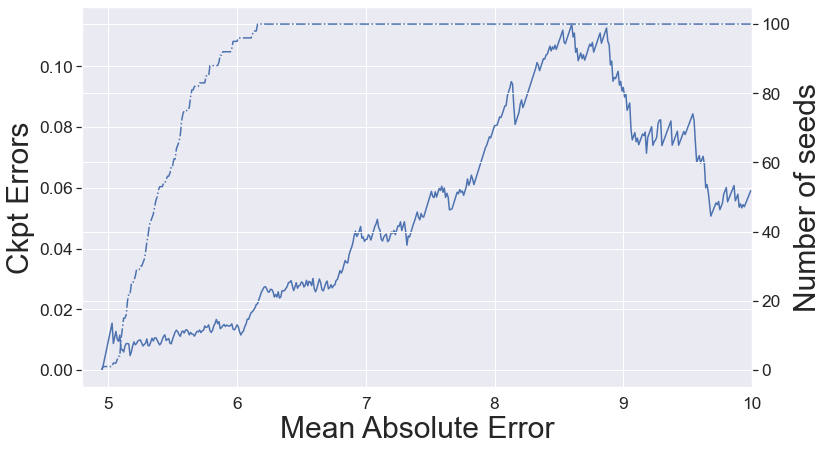

In [57]:
with open("./data/nonreg_ckpt_data_adjust.pkl", "rb") as f:
    nonreg_data = pickle.load(f)

fig, ax = plt.subplots(figsize=(12, 7))

adjusted_naive_num = list(
    map(
        lambda voxel, ckpts: voxel / (51 - ckpts // 2),
        nonreg_data["naive_nonzero"],
        nonreg_data["naive_num_ckpts"],
    )
)
adjusted_augment_num = list(
    map(
        lambda voxel, ckpts: voxel / (51 - ckpts // 2),
        nonreg_data["augment_nonzero"],
        nonreg_data["augment_num_ckpts"],
    )
)

ax.set_xlabel("Mean Absolute Error", size=30)
ax.set_ylabel("Ckpt Errors", size=30)

nonzero_linestyle = "-"
nonzero_linewidth = 1.5
ax.plot(
    x,
    y,
    linestyle=nonzero_linestyle,
    linewidth=nonzero_linewidth,
    label="Non-Aug. R.",
)
# ax.scatter()
ax.tick_params(axis="both", labelsize="xx-large")
ax.set_xlim(4.8, 10)
# yticklabels = [f"{i * 2.5}k" if i !=0 else "0" for i in range(8)]
# yticklabels = ["", "0", "10k", "20k", "30k", "40k", "50k"]
# ax.set_yticklabels(yticklabels)
# ax.set_ylim(.1, 50000)

ckpt_linestyle = "dashdot"
ckpt_linewidth = 1.5
ax2 = ax.twinx()
ax2.plot(
    x,
    naive_ckpts,
    linestyle=ckpt_linestyle,
    linewidth=ckpt_linewidth,
    label="Non-Aug. R.",
)
ax2.set_ylabel("Number of seeds", size=30)
ax2.tick_params(axis="y", labelsize="xx-large")
# ax2.legend(prop={"size": 18}, loc="upper left")
# fig.savefig("./figs/final_figs/nonzero_vox/el.png", pad_inches=0, bbox_inches="tight")

In [14]:
def pkl2npy(s, prefix="/Users/daehyuncho/codespace/brainmask_mni/", extension="npy"):

    s = "-".join(s.split("/")[-1].split("-")[1:])[:-4]

    prefix += s + f".{extension}"
    return prefix

In [15]:
conv_layers = []
def find_conv(module):

    for name, layer in module.named_children():
        if name.startswith("conv"):
            conv_layers.append(layer)
        elif list(layer.named_children()) == []:
            find_conv(layer)
        else:
            find_conv(layer)
    else:
        return

In [35]:
target_mae = 5.4
target_layer_index = 0
mni_shape = (99, 117, 95)

parent_paths = sorted(glob(f"{base_path}/*/*/"))
pre_registered = glob("../pre-registered/*.pkl")

test_dataloader = get_dataloader(data_args, misc_args, "test", logger)
test_dataset = test_dataloader.dataset
test_filelist = test_dataloader.dataset.data_files

2022-06-13 17:19:38,156 - root - INFO - Initialize dataset.
2022-06-13 17:19:38,166 - root - INFO - Successfully setup 146 brains for Test


In [36]:
training_args = TrainingArguments()
training_args.model_name = "repvgg"
model = build_model(training_args, logger)

model.find_conv(model)
model.conv_layers

2022-06-13 17:19:40,339 - root - INFO - Repvgg was chosen.
2022-06-13 17:19:40,369 - root - INFO - Repvgg has #params: 8 M.


[Conv3d(1, 38, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False),
 Conv3d(1, 38, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False),
 Conv3d(38, 38, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False),
 Conv3d(38, 38, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False),
 Conv3d(38, 76, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False),
 Conv3d(38, 76, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False),
 Conv3d(76, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False),
 Conv3d(76, 76, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False),
 Conv3d(76, 153, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False),
 Conv3d(76, 153, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False),
 Conv3d(153, 153, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False),
 Conv3d(153, 153, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False),
 Conv3d(153, 153, kernel_size=(3, 3, 3), s

In [37]:
ckpt_saliencies = {}
for parent_path in parent_paths:

    seed, test_result = result_pkl_parser(parent_path + "./result.pkl")
    converted_result = [(e[0], e[1]) for e in zip(test_result.index, test_result.values)]
    index, mae = find_first_reached(converted_result, target_mae)
    if index == -1:
        continue
    
    ckpt = f"{parent_path}ckpts/ep{str(index).zfill(3)}.pt"
    model.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")))
    assert os.path.exists(ckpt), f"This checkpoint should exist. Check: {ckpt}"

    layer_gc = LayerGradCam(model, model.conv_layers[target_layer_index])
    saliency_map = np.zeros(mni_shape)
    for pkl_fname in tqdm(pre_registered):

        npy_fname = pkl2npy(pkl_fname)
        npy_idx = test_filelist.index(npy_fname)
        x, y = test_dataset[npy_idx]
        with open(pkl_fname, "rb") as f:
            transform_matrix = pickle.load(f)

        attr = layer_gc.attribute(x[None, ...])
        upsampled_attr = (
            LayerAttribution.interpolate(
                attr, mni_shape, interpolate_mode="trilinear"
            )
            .cpu()
            .detach()
        )
        z_normed = z_norm(upsampled_attr)
        transformed_attr = transform_matrix["SymmetricDiffeomorphicRegistration"].transform(z_normed[0][0])
        saliency_map += transformed_attr
        
    saliency_map /= len(pre_registered)
    ckpt_saliencies[parent_path] = saliency_map

100%|██████████| 146/146 [00:22<00:00,  6.47it/s]


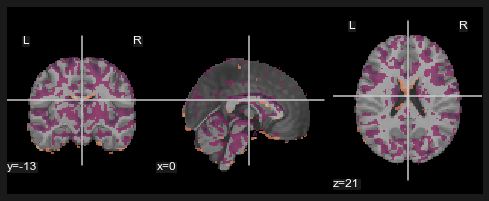

In [26]:
# Early, earlylayer
display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(saliency_map), alpha=0.7, threshold=0.1)

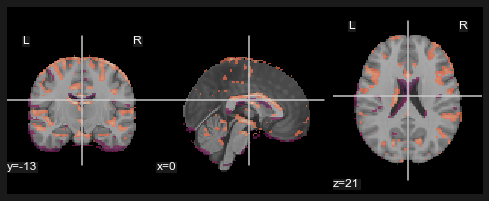

In [45]:
# Early, earlylayer target_mae=5.4, valid_runs=53
total_sal = sum(ckpt_saliencies.values()) / len(ckpt_saliencies)

display = plotting.plot_anat(load_mni152_template())
display.add_overlay(_mni(total_sal), alpha=0.7, threshold=0.02)